In [1]:
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')
!sudo apt-get -q update > /dev/null && sudo apt-get -q install -y tesseract-ocr-rus > /dev/null
!pip install -q pytesseract
%env PROJ_PATH=/content/drive/MyDrive/Colab_Notebooks/manuscript

Mounted at /content/drive
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
env: PROJ_PATH=/content/drive/MyDrive/Colab_Notebooks/manuscript


In [15]:
#libraries
import os
import cv2
import shutil
import numpy as np
import pytesseract
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from google.colab.patches import cv2_imshow

In [3]:
#paths
PATH = '/content/drive/MyDrive/Colab_Notebooks/manuscript/'
image_path = f'{PATH}test.png'
index_to_char = {
    0: '!',  1: ',',  2: '-',  3: '.',  4: ':',  5: ';',  6: '?',  7: 'Ё',  8: 'Ў',  9: 'А',
    10: 'Б', 11: 'В', 12: 'Г', 13: 'Д', 14: 'Е', 15: 'Ж', 16: 'З', 17: 'И', 18: 'Й', 19: 'К',
    20: 'Л', 21: 'М', 22: 'Н', 23: 'О', 24: 'п', 25: 'р', 26: 'с', 27: 'т', 28: 'у', 29: 'Ф',
    30: 'Х', 31: 'Ч', 32: 'Ш', 33: 'Э', 34: 'Ю', 35: 'Я', 36: 'а', 37: 'б', 38: 'в', 39: 'г',
    40: 'д', 41: 'е', 42: 'ж', 43: 'з', 44: 'и', 45: 'й', 46: 'к', 47: 'л', 48: 'м', 49: 'н',
    50: 'о', 51: 'П', 52: 'Р', 53: 'С', 54: 'Т', 55: 'у', 56: 'ф', 57: 'х', 58: 'ч', 59: 'ш',
    60: 'э', 61: 'ю', 62: 'я', 63: 'ё', 64: 'ў', 65: 'Ғ', 66: 'ғ', 67: 'Қ', 68: 'қ', 69: 'Ҳ',
    70: 'ҳ', 71: '—', 72: '”', 73: '„',
}

In [46]:
#functions

#############################################################################

def display_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

#############################################################################

class modelCNN(nn.Module):
    def __init__(self, num_classes=74):
        super(modelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.pool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#############################################################################

def draw_bounding_boxes(image_path, data, output_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at path {image_path}")
    boxes = []
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 0:
            top_left = [data['left'][i], data['top'][i]]
            w, h = data['width'][i], data['height'][i]
            x1, y1 = top_left
            bottom_right_x = x1 + w
            bottom_right_y = y1 + h
            cv2.rectangle(image, (x1, y1), (bottom_right_x, bottom_right_y), (0, 0, 255), 2)
            boxes.append((y1, x1, w, h))
    cv2.imwrite(output_path, image)
    return boxes

#############################################################################

def count_chars_in_box(image_path, data, box_index):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at path {image_path}")
    top_left = [data['left'][box_index], data['top'][box_index]]
    w, h = data['width'][box_index], data['height'][box_index]
    x1, y1 = top_left
    cropped_box = image[y1:y1+h, x1:x1+w]
    gray = cv2.cvtColor(cropped_box, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

#############################################################################

def count_contours_in_all_boxes(image_path, data):
    contour_counts = []
    for box_index in range(len(data['top'])):
        char_count = count_chars_in_box(image_path, data, box_index)
        contour_counts.append(char_count)
    return contour_counts

#############################################################################

def delete_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"The folder '{folder_path}' was deleted successfully.")
    else:
        print(f"The folder '{folder_path}' doesn't exist.")

#############################################################################

def save_contours_as_images(image_path, data, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at path {image_path}")
    contour_index = 0
    sorted_indices = sorted(range(len(data['left'])), key=lambda i: data['left'][i])
    for i in sorted_indices:
        top_left = [data['left'][i], data['top'][i]]
        w, h = data['width'][i], data['height'][i]
        x1, y1 = top_left
        cropped_box = image[y1:y1+h, x1:x1+w]
        gray = cv2.cvtColor(cropped_box, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
        for contour in contours:
            mask = cv2.drawContours(image.copy(), [contour], -1, (0, 0, 255), thickness=cv2.FILLED)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            x, y, w, h = cv2.boundingRect(contour)
            contour_img = mask[y:y+h, x:x+w]
            contour_resized = cv2.resize(contour_img, (28, 28), interpolation=cv2.INTER_AREA)
            contour_index += 1
            contour_filename = f"{output_folder}/contour_{contour_index}.png"
            cv2.imwrite(contour_filename, contour_resized)

#############################################################################

def process_boxes(image_path, contours_data, output_folder):
    for i in range(len(contours_data['top'])):
        box_data = {
            'top': [contours_data['top'][i]],
            'left': [contours_data['left'][i]],
            'width': [contours_data['width'][i]],
            'height': [contours_data['height'][i]]
        }
        box_output_folder = os.path.join(output_folder, f"box_{i+1}")
        save_contours_as_images(image_path, box_data, box_output_folder)

#############################################################################

def clean_text_in_boxes(image_path, data, output_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 24)
    for i in range(len(data['text'])):
        pos_y = data['line_num'][i]
        word = data['text'][i]
        if word != "":
            top_left = (data['left'][i], data['top'][i])
            bottom_right = (data['left'][i] + data['width'][i], data['top'][i] + data['height'][i])
            word_bbox = draw.textbbox((0, 0), word, font=font)
            word_width, word_height = word_bbox[2] - word_bbox[0], word_bbox[3] - word_bbox[1]
            draw.rectangle([top_left, bottom_right], fill=(255, 255, 255))
    pil_image = pil_image.convert("RGB")
    pil_image.save(output_path)

#############################################################################

def count_words(data_count):
    count = []
    p1, p2, cnt = 0, 0, 0
    index = data_count[0]
    for p2 in range(1, len(data_count)):
        if data_count[p2] == data_count[p1]:
            cnt += 1
        else:
            count.append(cnt)
            cnt = 0
            p1 = p2
    count.append(cnt)
    count = count[1:]
    count = [x for x in count if x != 0]
    return count

#############################################################################

def add_text_to_image(image_path, text_data, output_image_path, font_path="/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", font_size=23, line_spacing=5, count=[]):
    image = cv2.imread(image_path)
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image_pil)
    font = ImageFont.truetype(font_path, font_size)
    text = []
    for word in range(len(text_data['text'])):
        if text_data['text'][word] != "":
            text.append(text_data['text'][word])
    x, y = 20, 20
    color = (0, 0, 139)
    max_width = image_pil.width - 40
    line = ""
    word_index = 0
    line_index = 0
    count_iter = iter(count)
    while word_index < len(text):
        words_in_line = next(count_iter, None)
        if words_in_line is None:
            break
        line = ""
        for i in range(words_in_line):
            if word_index < len(text):
                line += text[word_index] + " "
                word_index += 1
        bbox = draw.textbbox((x, y), line, font=font)
        text_width = bbox[2] - bbox[0]
        if text_width <= max_width:
            draw.text((x, y), line, font=font, fill=color)
            bbox = draw.textbbox((x, y), line, font=font)
            y += bbox[3] - bbox[1] + line_spacing
        else:
            line = ""
            for i in range(words_in_line - 1):
                if word_index < len(text):
                    line += text[word_index] + " "
                    word_index += 1
            draw.text((x, y), line, font=font, fill=color)
            bbox = draw.textbbox((x, y), line, font=font)
            y += bbox[3] - bbox[1] + line_spacing
    image = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_image_path, image)
    return output_image_path

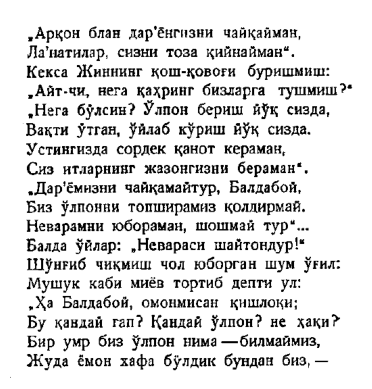

In [5]:
display_image(image_path)

In [6]:
!cd /content/ && python $PROJ_PATH/text_recognition.py --east $PROJ_PATH/frozen_east_text_detection.pb --image $PROJ_PATH/test.png --cmd /usr/bin/tesseract

[INFO] loading the detector...
[INFO] detection in 0.61 seconds


In [7]:
img = Image.open(image_path)
data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT, lang='rus')

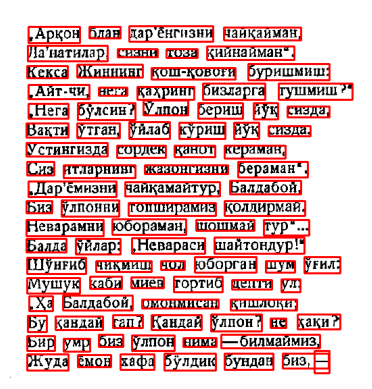

In [8]:
# Draw boxes
draw_bounding_boxes(image_path, data, 'boxes.png')
display_image('boxes.png')

In [44]:
# counting chars in every box
non_empty_text_indices = [i for i, t in enumerate(data["text"]) if t != ""]
contours_data = {key: [data[key][i] for i in non_empty_text_indices] for key in ["top", "left", "width", "height"]}
contour_counts = count_contours_in_all_boxes(image_path, contours_data)
print(contour_counts)

[6, 4, 12, 12, 10, 4, 4, 12, 5, 7, 10, 9, 7, 3, 7, 7, 6, 5, 7, 5, 4, 3, 6, 5, 7, 5, 5, 4, 6, 10, 5, 5, 8, 3, 9, 10, 9, 13, 12, 9, 3, 8, 9, 10, 9, 9, 7, 7, 5, 8, 9, 12, 6, 6, 3, 7, 3, 6, 5, 4, 6, 6, 4, 4, 3, 10, 9, 9, 2, 7, 4, 6, 6, 2, 5, 3, 2, 3, 6, 4, 11, 4, 5, 4, 8, 4, 5, 1]


In [48]:
# create folder with separate chars
process_boxes(image_path, contours_data, 'contours_output')

In [47]:
# delete folder (additional function)
# delete_folder("contours_output")

The folder 'contours_output' was deleted successfully.


In [56]:
# Model for recognize chars, work badly cause need more training data.

model = modelCNN(num_classes=74)
model.load_state_dict(torch.load(f'{PATH}recognition_chars_weights.pth', weights_only=True), strict=False)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def prepare_image(image):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    return transform(image).unsqueeze(0)

def recognize_characters_in_box(box_path, model):
    contour_files = sorted(os.listdir(box_path))
    results = []

    for contour_file in contour_files:
        contour_image_path = os.path.join(box_path, contour_file)
        contour_image = Image.open(contour_image_path).convert('L')
        tensor_image = prepare_image(contour_image)
        with torch.no_grad():
            output = model(tensor_image)
            _, predicted_class = torch.max(output, 1)
        predicted_char = index_to_char[predicted_class.item()]
        results.append((contour_file, predicted_char))
        print(f"Predicted for {contour_file}: {predicted_char}")
    return results

results = recognize_characters_in_box("contours_output/box_5", model)

Predicted for contour_1.png: Л
Predicted for contour_10.png: Т
Predicted for contour_2.png: !
Predicted for contour_3.png: ?
Predicted for contour_4.png: ш
Predicted for contour_5.png: ”
Predicted for contour_6.png: ,
Predicted for contour_7.png: Л
Predicted for contour_8.png: а
Predicted for contour_9.png: м


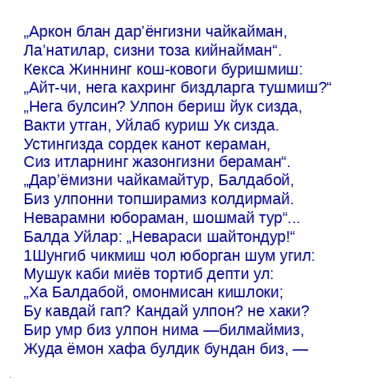

In [57]:
# Output ready text by tesseract_rus
data_count = data['line_num']
count = count_words(data_count)
clean_text_in_boxes(image_path, data, 'image_with_text.png')
add_text_to_image('image_with_text.png', data, 'image_with_text.png', count=count)
display_image('image_with_text.png')